# Detecção de Spams

1. Ler dados
2. Processar textos
3. Representação Textual
4. Classificação
5. Métricas 

## 1. Ler dados

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

base = pd.read_csv('drive/My Drive/spam.csv', encoding='latin-1')
base.dropna(how="any", inplace=True, axis=1)
base.columns = ['label', 'message']

base.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
base['label'].value_counts()

ham     4825
spam     747
Name: label, dtype: int64

In [ ]:
base['label_num'] = base.label.map({'ham':0, 'spam':1})

base.head()

,label,message,label_num
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


## 2. Processamento do texto

1. Deixar tudo em minúsculo
2. Remover símbolos fora do alfabeto
3. Tokenizer
4. Remover Palavras Vazias
5. Normalizar 
6. Retornar para texto

### 1. Deixando tudo em minúsculo

In [ ]:
mensagens = base['message']

mensagens[0:5]

0    Go until jurong point, crazy.. Available only ...
1                        Ok lar... Joking wif u oni...
2    Free entry in 2 a wkly comp to win FA Cup fina...
3    U dun say so early hor... U c already then say...
4    Nah I don't think he goes to usf, he lives aro...
Name: message, dtype: object

In [ ]:
from tqdm.notebook import tqdm
tqdm.pandas()

mensagens = mensagens.progress_apply(lambda m: m.lower())

mensagens[0:5]

0    go until jurong point, crazy.. available only ...
1                        ok lar... joking wif u oni...
2    free entry in 2 a wkly comp to win fa cup fina...
3    u dun say so early hor... u c already then say...
4    nah i don't think he goes to usf, he lives aro...
Name: message, dtype: object

### 2. Removendo símbolos

In [ ]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

In [ ]:
#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

In [ ]:
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text

In [ ]:
from bs4 import BeautifulSoup
import re,string,unicodedata

#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_special_characters(text)
    return text

In [ ]:
mensagens = mensagens.progress_apply(denoise_text)

mensagens[0:5]

0    go until jurong point crazy available only in ...
1                              ok lar joking wif u oni
2    free entry in 2 a wkly comp to win fa cup fina...
3          u dun say so early hor u c already then say
4    nah i dont think he goes to usf he lives aroun...
Name: message, dtype: object

### 3. Tokenizer

In [ ]:
mensagens = mensagens.progress_apply(lambda m: m.split(' '))

mensagens[0:5]

0    [go, until, jurong, point, crazy, available, o...
1                       [ok, lar, joking, wif, u, oni]
2    [free, entry, in, 2, a, wkly, comp, to, win, f...
3    [u, dun, say, so, early, hor, u, c, already, t...
4    [nah, i, dont, think, he, goes, to, usf, he, l...
Name: message, dtype: object

### 4. Removendo palavras vazias (stop words)

In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

def remove_stopwords(tokens, language='english'):
    stopword = stopwords.words(language)
    text = [word for word in tokens if word not in stopword]
    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
mensagens = mensagens.progress_apply(remove_stopwords)

mensagens[0:5]

0    [go, jurong, point, crazy, available, bugis, n...
1                       [ok, lar, joking, wif, u, oni]
2    [free, entry, 2, wkly, comp, win, fa, cup, fin...
3        [u, dun, say, early, hor, u, c, already, say]
4    [nah, dont, think, goes, usf, lives, around, t...
Name: message, dtype: object

###5. Normalizar

#### Com Lemmatizing

In [ ]:
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

def lemmatizing(tokens):
    wn = WordNetLemmatizer()
    text = [wn.lemmatize(word) for word in tokens]
    return text

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
mensagens_lem = mensagens.progress_apply(lemmatizing)

mensagens_lem[0:5]

0    [go, jurong, point, crazy, available, bugis, n...
1                       [ok, lar, joking, wif, u, oni]
2    [free, entry, 2, wkly, comp, win, fa, cup, fin...
3        [u, dun, say, early, hor, u, c, already, say]
4    [nah, dont, think, go, usf, life, around, though]
Name: message, dtype: object

#### Com Stemming

In [ ]:
from nltk.stem.porter import PorterStemmer

def stemming(tokens):
    ps = PorterStemmer()
    text = [ps.stem(word) for word in tokens]
    return text

In [ ]:
mensagens_stem = mensagens.progress_apply(stemming)

mensagens_stem[0:5]

0    [go, jurong, point, crazi, avail, bugi, n, gre...
1                         [ok, lar, joke, wif, u, oni]
2    [free, entri, 2, wkli, comp, win, fa, cup, fin...
3        [u, dun, say, earli, hor, u, c, alreadi, say]
4    [nah, dont, think, goe, usf, live, around, tho...
Name: message, dtype: object

### Retornar para texto

In [ ]:
mensagens = mensagens.progress_apply(lambda t: ' '.join(t))
mensagens_lem = mensagens_lem.progress_apply(lambda t: ' '.join(t))
mensagens_stem = mensagens_stem.progress_apply(lambda t: ' '.join(t))

In [ ]:
mensagens[0: 5]

0    go jurong point crazy available bugis n great ...
1                              ok lar joking wif u oni
2    free entry 2 wkly comp win fa cup final tkts 2...
3                  u dun say early hor u c already say
4          nah dont think goes usf lives around though
Name: message, dtype: object

In [ ]:
mensagens_lem[0:5]

0    go jurong point crazy available bugis n great ...
1                              ok lar joking wif u oni
2    free entry 2 wkly comp win fa cup final tkts 2...
3                  u dun say early hor u c already say
4             nah dont think go usf life around though
Name: message, dtype: object

In [ ]:
mensagens_stem[0:5]

0    go jurong point crazi avail bugi n great world...
1                                ok lar joke wif u oni
2    free entri 2 wkli comp win fa cup final tkt 21...
3                  u dun say earli hor u c alreadi say
4            nah dont think goe usf live around though
Name: message, dtype: object

In [ ]:
base['message_sem_norm'] = mensagens
base['message_lem'] = mensagens_lem
base['message_stem'] = mensagens_stem

base.head()

,label,message,message_sem_norm,message_lem,message_stem
0,ham,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis n great ...,go jurong point crazy available bugis n great ...,go jurong point crazi avail bugi n great world...
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni,ok lar joking wif u oni,ok lar joke wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...,free entry 2 wkly comp win fa cup final tkts 2...,free entri 2 wkli comp win fa cup final tkt 21...
3,ham,U dun say so early hor... U c already then say...,u dun say early hor u c already say,u dun say early hor u c already say,u dun say earli hor u c alreadi say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah dont think goes usf lives around though,nah dont think go usf life around though,nah dont think goe usf live around though


## Representação do texto & Classificação

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

x_train, x_test = train_test_split(mensagens_lem, test_size=0.2, random_state=42)
vectorizer = TfidfVectorizer(ngram_range=(1, 1), analyzer='char', max_features=100)
vectorizer.fit(x_train)


TfidfVectorizer(analyzer='char', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=100,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [ ]:
vectorizer.vocabulary_

{'\r': 0,
 ' ': 1,
 '0': 2,
 '1': 3,
 '2': 4,
 '3': 5,
 '4': 6,
 '5': 7,
 '6': 8,
 '7': 9,
 '8': 10,
 '9': 11,
 '\\': 12,
 '^': 13,
 '_': 14,
 'a': 15,
 'b': 16,
 'c': 17,
 'd': 18,
 'e': 19,
 'f': 20,
 'g': 21,
 'h': 22,
 'i': 23,
 'j': 24,
 'k': 25,
 'l': 26,
 'm': 27,
 'n': 28,
 'o': 29,
 'p': 30,
 'q': 31,
 'r': 32,
 's': 33,
 't': 34,
 'u': 35,
 'v': 36,
 'w': 37,
 'x': 38,
 'y': 39,
 'z': 40}

In [ ]:
vectors = vectorizer.transform(x_train).todense()

vectors[0]

matrix([[0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.84109427, 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0

In [ ]:
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.svm import SVC, LinearSVC
from sklearn import metrics

def classificacao(corpus, y):
    split = 5
    kf = KFold(n_splits=split, shuffle=True, random_state=0)
    y_t = []
    y_p = []

    for train_index, test_index in tqdm(kf.split(corpus), total=split):
        # print("TRAIN:", train_index, "TEST:", test_index)
        
        x_train, x_test = corpus[train_index], corpus[test_index]
        vectorizer = TfidfVectorizer(ngram_range=(1, 1))
        # vectorizer = CountVectorizer()
        
        x_train = vectorizer.fit_transform(x_train)
        x_test = vectorizer.transform(x_test)
        
        # print(x_train.shape, x_test.shape)

        y_train, y_test = y[train_index], y[test_index]

        clf = SVC(kernel='linear')
        # clf = LinearSVC()
        clf.fit(x_train, y_train.ravel())
        y_pred = clf.predict(x_test)

        y_t.extend(y_test)
        y_p.extend(y_pred)

    return y_t, y_p

In [ ]:
y_t, y_p = classificacao(base['message_lem'], base['label_num'])

In [ ]:
import numpy as np
matriz_confusao = metrics.confusion_matrix(y_t, y_p, labels=[1, 0])

print('Matrix de Confusão')
print(matriz_confusao)

Matrix de Confusão
[[ 662   85]
 [  14 4811]]


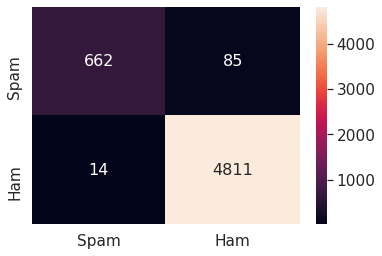

In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt
pd.set_option('display.float_format', lambda x: '%.3f' % x)

df_cm = pd.DataFrame(matriz_confusao, range(2), range(2))
sn.set(font_scale=1.4) # for label size
labels = ['Spam', 'Ham']
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16, }, fmt='g', xticklabels=labels, yticklabels=labels) # font size
plt.show()

In [ ]:
print(f'Acuracia: {metrics.accuracy_score(y_t, y_p)}')
print(f'Precisao: {metrics.precision_score(y_t, y_p)}')
print(f'Revocação: {metrics.recall_score(y_t, y_p)}')
print(f'F1-Score: {metrics.f1_score(y_t, y_p)}')

Acuracia: 0.9822325915290739
Precisao: 0.9792899408284024
Revocação: 0.8862115127175368
F1-Score: 0.9304286718200985
